# This notebook computes average length of tweets and produces word clouds for important vocabulary in the hybrid dataset

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import re
import torch
import random
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
raw_dataset =pd.read_csv('/content/drive/MyDrive/Capstone Project Files CS/Datasets/Processed Datasets/project_dataset.csv')

In [ ]:
raw_dataset= pd.read_csv('/content/drive/MyDrive/Capstone Project Files CS/Datasets/Processed Datasets/project_dataset_withNERSTEM.csv')

In [ ]:
raw_dataset=raw_dataset.drop(labels='Unnamed: 0', axis=1)

In [ ]:
raw_dataset.head()

,origin,tweet_text,tweet_text_NER,tweet_text_NER_STEM,label
0,ARC,الكورونا الطريقة الصحيحة لاستخدام الكمامات لاح...,الكورونا الطريقة الصحيحة لاستخدام الكمامات لاح...,كورونا طريقة صحيح استخدام كمام لاحظ عام ناس ما...,False
1,MFH,كونا | إصابة أنثى نمر في حديقة حيوان بمدينة (ن...,PER | إصابة أنثى نمر في حديقة حيوان بمدينة (...,PER | إصابة أنثى مر في حديقة حيوان مدينة ( LOC...,True
2,ARC,في مشهد مهيب تقشعر له الأبدان. خرج العاملون في...,في مشهد مهيب تقشعر له الأبدان. خرج العاملون في...,في مشهد مهيب تقشعر ل بدن . خرج عامل في مستشفى ...,True
3,4IF,بعد كسر حاجز 10000 أصابه نشطة في قطر ،، وزارة ...,بعد كسر حاجز 10000 أصابه نشطة في LOC ،، وزار...,بعد كسر حاجز 10000 أصاب نشط في LOC ، ، وزارة ت...,True
4,ARC,الواضح من الأرقام أن كورونا_الجديد COVID 19 يع...,الواضح من الأرقام أن MISC MISC يعرض المدخن...,واضح من رقم أن MISC MISC عرض مدخن كبير سن مرض ...,True


In [ ]:
!pip install transformers==4.12.2
!pip install farasapy==0.0.14
!pip install pyarabic==0.6.14
!git clone https://github.com/aub-mind/arabert
!pip install emoji==1.6.1
!pip install sentencepiece==0.1.96

     |████████████████████████████████| 3.1 MB 4.9 MB/s 
     |████████████████████████████████| 880 kB 34.5 MB/s 
     |████████████████████████████████| 596 kB 20.4 MB/s 
     |████████████████████████████████| 3.3 MB 38.8 MB/s 
     |████████████████████████████████| 84 kB 2.6 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=afed922aeec4bdf0f0d9758ee09bd4f933fa7597fdc09853b7d73156cd5d968e
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 126 kB 4.2 MB/s 
Cloning into 'arabert'...
remote: Enumerating objects: 564, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 564 (delta 25), reused 22 (delta 22),

In [ ]:
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import copy
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer)

In [ ]:
model_name = 'aubmindlab/bert-base-arabertv02-twitter' # we are going to use the twitter AraBERT since it has emojis and dialects
tok = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/476 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/733k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Tweet lengths

Full dataset

Training Sentence Lengths: in terms of characters


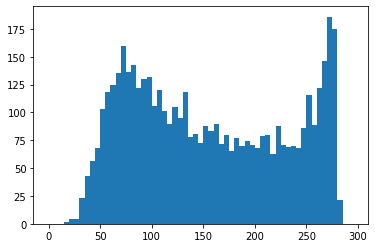

In [ ]:
print("Tweet length (Number of characters)")
plt.hist([ len(tweet) for tweet in raw_dataset['tweet_text'].to_list()],bins=range(0,300,5))
plt.show()

Tweet  Length in terms of words: 


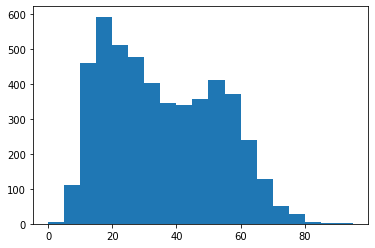

In [ ]:
print("Tweet  Length in terms of words: ")
plt.hist([ len(tok.tokenize(tweet))  for tweet in raw_dataset['tweet_text'].to_list()],bins=range(0,100,5))
plt.show()

True set

In [ ]:
true_set=raw_dataset.loc[raw_dataset['label']==True]

Tweet length (Number of characters)


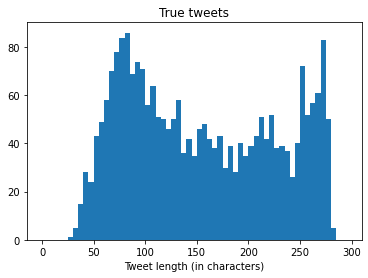

In [ ]:
print("Tweet length (Number of characters)")
plt.hist([ len(tweet) for tweet in true_set['tweet_text'].to_list()],bins=range(0,300,5))
plt.xlabel('Tweet length (in characters)')
plt.show()

In [ ]:
min=10000
max = 0
sum=0

for tweet in true_set['tweet_text'].to_list():
    if len(tweet) < min:
      min=len(tweet)
    if len(tweet) > max:
      max=len(tweet)
    sum+=len(tweet)
avg=sum/len(true_set['tweet_text'].to_list())
print(min)
print(max)
print(avg)

29
280
154.4605208763952


Tweet  Length in terms of words: 


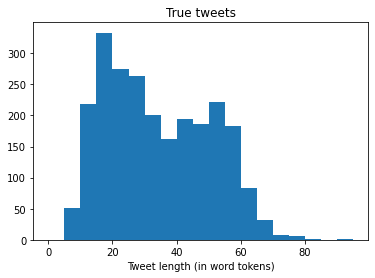

In [ ]:
print("Tweet  Length in terms of words: ")
plt.hist([ len(tok.tokenize(tweet))   for tweet in true_set['tweet_text'].to_list()],bins=range(0,100,5))
plt.xlabel('Tweet length (in word tokens)')
plt.show()

In [ ]:
min=10000
max = 0
sum=0
for tweet in true_set['tweet_text'].to_list():
    token_list=tok.tokenize(tweet)
    if len(token_list) < min:
      min=len(token_list)
    if len(token_list) > max:
      max=len(token_list)
    sum+=len(token_list)
avg=sum/len(true_set['tweet_text'].to_list())
print(min)
print(max)
print(avg)

6
93
33.757751136833406


False

In [ ]:
false_set=raw_dataset.loc[raw_dataset['label']==False]

Training Sentence Lengths: 


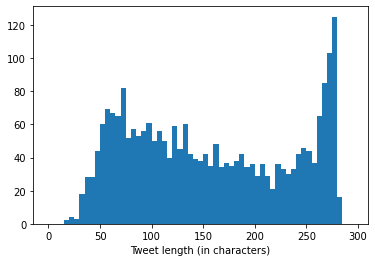

In [ ]:
print("Training Sentence Lengths: ")
plt.hist([ len(tweet) for tweet in false_set['tweet_text'].to_list()],bins=range(0,300,5))
plt.xlabel('Tweet length (in characters)')
plt.show()

In [ ]:
min=10000
max = 0
sum=0

for tweet in false_set['tweet_text'].to_list():
    if len(tweet) < min:
      min=len(tweet)
    if len(tweet) > max:
      max=len(tweet)
    sum+=len(tweet)
avg=sum/len(false_set['tweet_text'].to_list())
print(min)
print(max)
print(avg)

15
280
156.87267465895


Tweet  Length in terms of words: 


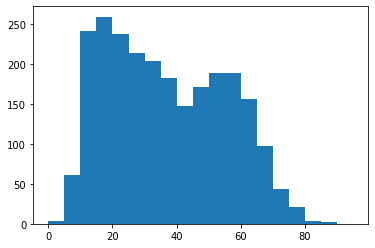

In [ ]:
print("Tweet  Length in terms of words: ")
plt.hist([ len(tok.tokenize(tweet))   for tweet in false_set['tweet_text'].to_list()],bins=range(0,100,5))
plt.xlabel('Tweet length (in word tokens)')
plt.show()

In [ ]:
min=10000
max = 0
sum=0
for tweet in false_set['tweet_text'].to_list():
    token_list=tok.tokenize(tweet)
    if len(token_list) < min:
      min=len(token_list)
    if len(token_list) > max:
      max=len(token_list)
    sum+=len(token_list)
avg=sum/len(false_set['tweet_text'].to_list())
print(min)
print(max)
print(avg)

3
85
36.42207523770153


# Count Vectorizer

In [ ]:
!pip install arabic_reshaper
!pip install python-bidi

In [ ]:
import arabic_reshaper
from bidi.algorithm import get_display
import seaborn as sns

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

In [ ]:
arabic_stop_words=[]
with open('/content/drive/MyDrive/Capstone Project Files CS/Datasets/arabic_stop_words.txt') as file:
    for line in file:
        arabic_stop_words.append(line.rstrip())

In [ ]:
raw_dataset.head()

,origin,tweet_text,tweet_text_NER,tweet_text_NER_STEM,label
0,ARC,الكورونا الطريقة الصحيحة لاستخدام الكمامات لاح...,الكورونا الطريقة الصحيحة لاستخدام الكمامات لاح...,كورونا طريقة صحيح استخدام كمام لاحظ عام ناس ما...,False
1,MFH,كونا | إصابة أنثى نمر في حديقة حيوان بمدينة (ن...,PER | إصابة أنثى نمر في حديقة حيوان بمدينة (...,PER | إصابة أنثى مر في حديقة حيوان مدينة ( LOC...,True
2,ARC,في مشهد مهيب تقشعر له الأبدان. خرج العاملون في...,في مشهد مهيب تقشعر له الأبدان. خرج العاملون في...,في مشهد مهيب تقشعر ل بدن . خرج عامل في مستشفى ...,True
3,4IF,بعد كسر حاجز 10000 أصابه نشطة في قطر ،، وزارة ...,بعد كسر حاجز 10000 أصابه نشطة في LOC ،، وزار...,بعد كسر حاجز 10000 أصاب نشط في LOC ، ، وزارة ت...,True
4,ARC,الواضح من الأرقام أن كورونا_الجديد COVID 19 يع...,الواضح من الأرقام أن MISC MISC يعرض المدخن...,واضح من رقم أن MISC MISC عرض مدخن كبير سن مرض ...,True


In [ ]:
#CountVectorizer
count_vectorizer = CountVectorizer(stop_words=arabic_stop_words)
count_vectorizer.fit((raw_dataset['tweet_text_NER_STEM']))
vectorized = count_vectorizer.transform(raw_dataset['tweet_text_NER_STEM'])
print('The transformed data matrix dimensions:', vectorized.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد', 'قط', 'كأي', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هاك', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)


The transformed data matrix dimensions: (4838, 8015)


In [ ]:
word_list_1_gram = count_vectorizer.get_feature_names()
count_list_1_gram = np.asarray(vectorized.sum(axis=0))[0]
word_freq_dict_1_gram=dict(zip(word_list_1_gram , count_list_1_gram))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
word_freq_dict_1_gram_sorted=sorted(word_freq_dict_1_gram.items(), key=lambda item: item[1], reverse=True)

In [ ]:
word_freq_dict_1_gram_sorted[0:20]

[('كورونا', 5028),
 ('loc', 4595),
 ('فيروس', 3224),
 ('per', 2174),
 ('لقاح', 1634),
 ('misc', 1079),
 ('الله', 886),
 ('إصابة', 852),
 ('org', 798),
 ('صحة', 663),
 ('جديد', 577),
 ('أعلن', 540),
 ('عالم', 536),
 ('19', 445),
 ('مرض', 390),
 ('مستجد', 389),
 ('وفاة', 385),
 ('رئيس', 374),
 ('حالة', 361),
 ('علاج', 352)]

True Set

In [ ]:
#CountVectorizer
count_vectorizer_true = CountVectorizer(stop_words=arabic_stop_words)
count_vectorizer_true.fit((true_set['tweet_text_NER_STEM']))
vectorized_true = count_vectorizer_true.transform(true_set['tweet_text_NER_STEM'])
print('The transformed data matrix dimensions:', vectorized.shape)

The transformed data matrix dimensions: (2419, 4637)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد', 'قط', 'كأي', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هاك', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
word_list_1_gram_true = count_vectorizer_true.get_feature_names()
count_list_1_gram_true = np.asarray(vectorized_true.sum(axis=0))[0]
word_freq_dict_1_gram_true=dict(zip(word_list_1_gram_true , count_list_1_gram_true))
word_freq_dict_1_gram_sorted_true=sorted(word_freq_dict_1_gram_true.items(), key=lambda item: item[1], reverse=True)
word_freq_dict_1_gram_sorted_true[0:20]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('كورونا', 2513),
 ('loc', 1969),
 ('فيروس', 1744),
 ('لقاح', 1050),
 ('per', 877),
 ('misc', 563),
 ('صحة', 512),
 ('إصابة', 496),
 ('الله', 479),
 ('org', 474),
 ('جديد', 413),
 ('19', 349),
 ('وفاة', 323),
 ('أعلن', 285),
 ('حالة', 269),
 ('مستجد', 269),
 ('كوفيد', 224),
 ('مصاب', 205),
 ('سلوان', 204),
 ('مرض', 202)]

In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:
## Creating a function to generate a wordcloud to see how the words are distributed
img_count = 0
def get_wordcloud(token_freq):
  global img_count


  wordcloud = WordCloud(width = 1200, height = 600, 
              background_color ='white', stopwords=arabic_stop_words, font_path='/content/drive/MyDrive/Capstone Project Files CS/Datasets/Processed Datasets/NotoNaskhArabic-Regular.ttf'
              ,min_font_size = 10).generate_from_frequencies(token_freq)
  plt.figure(figsize = (12, 6), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.title("True Class", fontsize=20)
  plt.tight_layout(pad = 0)
  figname = 'wordcloud'+ str(img_count)
  plt.savefig(figname) 
  img_count+=1

In [ ]:
 word_freq_dict_1_gram_true["حديقة"]

36

In [ ]:
foreign_items=[]
print (len(word_freq_dict_1_gram_true))
for token in list(word_freq_dict_1_gram_true.keys()):
  if re.search(r'[0-9]+', token):
    foreign_items.append(token)
    word_freq_dict_1_gram_true.pop(token)



print(foreign_items)
print(len(word_freq_dict_1_gram_true))

4637
['00', '000', '01', '03', '05', '07', '08', '09', '10', '100', '1000', '10000', '1000000', '1004', '1009', '103', '104', '1047', '105', '107', '108', '10810', '11', '11031', '1111', '112', '1124', '116', '1171', '118', '12', '120', '1200', '121', '1223', '123', '12445', '125', '1251', '126', '1261', '12685', '12868', '129', '1293', '12968', '13', '130', '1300', '131', '132', '13273', '135', '136', '137', '1370', '14', '140', '1400', '1423', '144', '1440', '1441', '1442', '146', '1470', '1479', '149', '1491', '14953', '15', '150', '1500', '15000', '1523', '153', '15500', '159', '16', '1600', '16404', '1651', '1666', '169', '1696', '17', '170', '171', '17261', '173', '17348', '176', '179', '18', '182', '185', '18712', '188', '189', '1892', '19', '190', '191', '1914', '1936', '195', '1957', '197', '1981', '1983', '1996', '19covid19', '19dz', '20', '200', '2000', '2003', '2008', '2012', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '205', '2058', '21', '213', '2160',

In [ ]:
foreign_items=[]
print (len(word_freq_dict_1_gram_true))
for token in list(word_freq_dict_1_gram_true.keys()):
  if re.search(r'[A-Za-z]+', token):
    foreign_items.append(token)
    word_freq_dict_1_gram_true.pop(token)



print(foreign_items)
print(len(word_freq_dict_1_gram_true))

4298
['abood', 'about', 'albarjeel', 'alexander', 'alger', 'algeria', 'algerie', 'algiers', 'alwakaai', 'and', 'andalusiawithyou', 'atos', 'bad', 'barqhealth', 'bbc', 'bdf', 'beyondhealthcare', 'bh', 'blida', 'cdc', 'china', 'choosetovaccinate', 'cia', 'cnn', 'commit', 'committowin', 'confinement', 'confr', 'coro', 'corona', 'coronaupdate', 'coronavir', 'coronavirus', 'coronavirusalgeria', 'coronavirusfact', 'coronavirusmaroc', 'coronavirusoutbreak', 'coronavirusupdate', 'coronavirusupdates', 'coronavius', 'covid', 'credit', 'cure', 'daily', 'darkness', 'datos', 'datoscoronavirus', 'dna', 'drive', 'dubai', 'dz', 'dza', 'early', 'econseilbook', 'ecuador', 'ecuadorcoronavirus', 'en', 'ereborn', 'est', 'extranews', 'factcheck', 'facts', 'fadelzoubir', 'fake', 'fakenews', 'family', 'fda', 'final', 'for', 'forqatarstayhome', 'from', 'grand', 'guayaquil', 'health', 'hemaida', 'hour', 'hpg', 'humans', 'it', 'kangtai', 'khaberni', 'loc', 'medic', 'misc', 'mon', 'mrna', 'national', 'navigation'

In [ ]:
  for token in list(word_freq_dict_1_gram_true.keys()):
    text= arabic_reshaper.reshape(token)
    text= get_display(text)
    word_freq_dict_1_gram_true[text]=word_freq_dict_1_gram_true.pop(token)

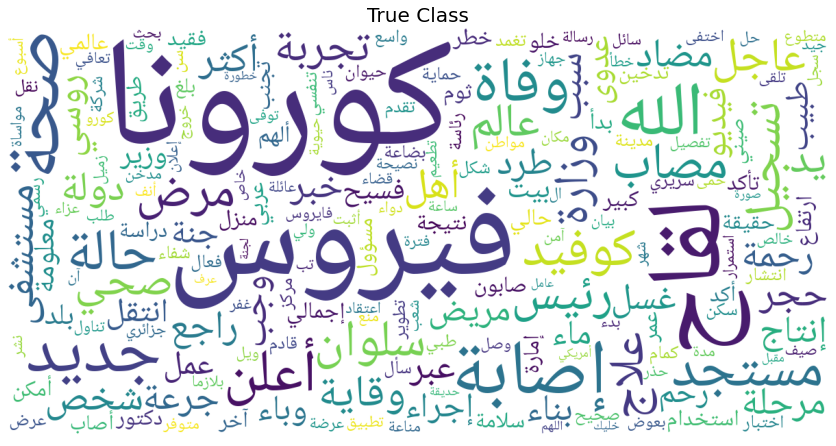

In [ ]:
get_wordcloud(word_freq_dict_1_gram_true)

In [ ]:
word_freq_dict_1_gram_sorted_true=sorted(word_freq_dict_1_gram_true.items(), key=lambda item: item[1])

False

In [ ]:
count_vectorizer_false = CountVectorizer(stop_words=arabic_stop_words)
count_vectorizer_false.fit((false_set['tweet_text_NER_STEM']))
vectorized_false = count_vectorizer_true.transform(false_set['tweet_text_NER_STEM'])
print('The transformed data matrix dimensions:', vectorized.shape)

The transformed data matrix dimensions: (2419, 4637)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد', 'قط', 'كأي', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هاك', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
word_list_1_gram_false = count_vectorizer_false.get_feature_names()
count_list_1_gram_false = np.asarray(vectorized_false.sum(axis=0))[0]
word_freq_dict_1_gram_false=dict(zip(word_list_1_gram_false , count_list_1_gram_false))
word_freq_dict_1_gram_sorted_false=sorted(word_freq_dict_1_gram_false.items(), key=lambda item: item[1], reverse=True)
word_freq_dict_1_gram_sorted_false[0:20]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('أستمعت', 2626),
 ('ضرر', 2515),
 ('شعبي', 1480),
 ('أسهل', 1297),
 ('طريق', 584),
 ('أسد', 516),
 ('العالميه', 407),
 ('زغلول', 365),
 ('اتباع', 356),
 ('أسلام', 324),
 ('صحة', 280),
 ('إجانا', 255),
 ('ظاهرة', 253),
 ('ظفر', 249),
 ('10000', 213),
 ('جنازة', 212),
 ('غامالي', 188),
 ('حديث', 180),
 ('ماري', 179),
 ('تع', 176)]

In [ ]:
foreign_items=[]
print (len(word_freq_dict_1_gram_false))
for token in list(word_freq_dict_1_gram_false.keys()):
  if re.search(r'[0-9]+', token):
    foreign_items.append(token)
    word_freq_dict_1_gram_false.pop(token)



print(foreign_items)
print(len(word_freq_dict_1_gram_false))

4637
['000', '00000000000000000000000000000', '000000000000000000000000000000', '011', '0522878900', '06', '10', '100', '1000', '10000', '100972522878900', '101', '108', '11', '12', '13', '139', '14', '15', '150', '1510', '155', '16', '165', '170', '1720', '173', '18', '1820', '19', '1918', '1920', '1957', '1961', '1973', '1981', '1982', '1984', '1990', '1991', '1993', '19covidالأطباء', '20', '200', '2000', '2001', '2003', '2004', '2011', '2013', '2017', '2018', '2019', '2020', '2021', '2022', '206', '21', '24', '244', '2450', '25', '2500', '258', '26', '2600', '27', '28', '29', '292', '30', '300', '30000', '31', '3104', '313', '32', '33', '3405', '35', '3500', '365', '37', '39', '40', '400', '426', '448', '45', '463', '48', '50', '500', '5000', '50000', '51', '525', '53', '55', '56', '58', '583', '5g', '60', '600', '6000', '60000', '603', '6060', '61', '63', '67', '70', '700', '700000', '72', '74', '75', '750', '76', '793', '80', '800', '8221', '862', '885', '89', '90', '900', '94', '

In [ ]:
foreign_items=[]
print (len(word_freq_dict_1_gram_false))
for token in list(word_freq_dict_1_gram_false.keys()):
  if re.search(r'[A-Za-z]+', token):
    foreign_items.append(token)
    word_freq_dict_1_gram_false.pop(token)



print(foreign_items)
print(len(word_freq_dict_1_gram_false))

4487
['above', 'adenovirus', 'algeria', 'algerie', 'almashadel', 'are', 'bay', 'bci', 'betadine', 'bill', 'blog', 'boxed', 'bullet', 'cdf', 'children', 'china', 'chiroptera', 'cnn', 'committowin', 'control', 'coro', 'corona', 'coronadebat', 'coronaviruesue', 'coronavirus', 'coronaviruse', 'coronavirusec', 'coronavirusoutbreak', 'coronavirusupdate', 'coronaviruswho', 'coronvirus', 'covid', 'dari', 'darkness', 'disease', 'eden', 'etiquette', 'eye', 'eyes', 'feedly', 'for', 'healthnerds', 'hospital', 'in', 'indonesia', 'infection', 'institut', 'iq', 'it', 'italy', 'italycoronavirus', 'just', 'ka', 'kidding', 'kspsh', 'lebanon', 'liars', 'loc', 'low', 'lunches', 'made', 'misc', 'mtv', 'mtvlebanon', 'new', 'news', 'oat', 'of', 'on', 'org', 'pandemic', 'pardon', 'pasteur', 'pcr', 'pdate', 'per', 'phase', 'pona', 'posted', 'prayforitaly', 'quarantine', 'reatens', 'recombinant', 'research', 'retwit', 'rna', 'russianvaccine', 'sarin', 'signs', 'silver', 'slowing', 'sore', 'sorry', 'stayathome',

In [ ]:
  for token in list(word_freq_dict_1_gram_false.keys()):
    text= arabic_reshaper.reshape(token)
    text= get_display(text)
    word_freq_dict_1_gram_false[text]=word_freq_dict_1_gram_false.pop(token)

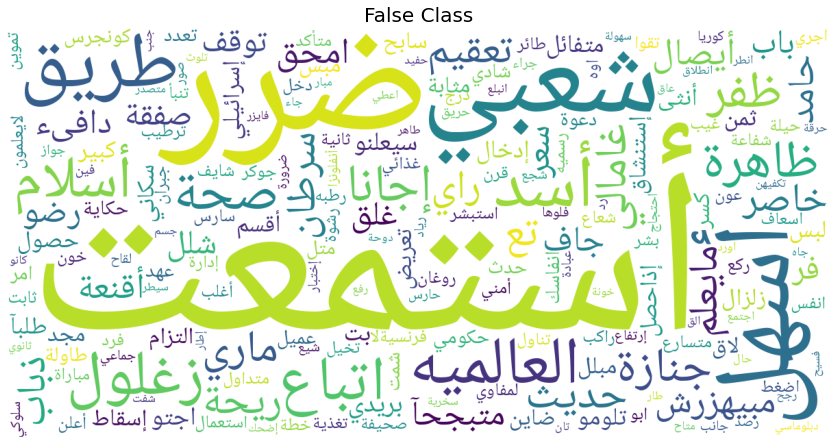

In [ ]:
get_wordcloud(word_freq_dict_1_gram_false)

# TF-IDF

In [ ]:
#TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=arabic_stop_words)
tfidf_vectorizer.fit((true_set['tweet_text_NER_STEM']))
tfidf_vectorized = tfidf_vectorizer.transform(true_set['tweet_text_NER_STEM'])
print('The transformed data matrix dimensions:', vectorized.shape)

The transformed data matrix dimensions: (2419, 4637)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد', 'قط', 'كأي', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هاك', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)


In [ ]:


tfidf = tfidf_vectorized.todense()
# TFIDF of words not in the doc will be 0, so replace them with nan
tfidf[tfidf == 0] = np.nan
# Use nanmean of numpy which will ignore nan while calculating the mean
means = np.nanmean(tfidf, axis=0)
# convert it into a dictionary for later lookup
means = dict(zip(tfidf_vectorizer.get_feature_names(), means.tolist()[0]))

tfidf = tfidf_vectorized.todense()
# Argsort the full TFIDF dense vector
ordered = np.argsort(tfidf*-1)
words = tfidf_vectorizer.get_feature_names()
tfidf_dict = {}
top_k = 3
for i in range(len(true_set['tweet_text_NER_STEM'])):
    # Pick top_k from each argsorted matrix for each doc
    for t in range(top_k):
        # Pick the top k word, find its average tfidf from the
        # precomputed dictionary using nanmean and save it to later use
        tfidf_dict[words[ordered[i,t]]] = means[words[ordered[i,t]]]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
tf_idf_dict_sorted=sorted(tfidf_dict.items(), key=lambda item: item[1], reverse=True)

In [ ]:
count=0
for item in tfidf_dict:
  print(item, tfidf_dict[item])
  if count > 20:
    break
  count+=1

حيوان 0.3296741123346482
أنثى 0.3036635310650181
سؤال 0.24288875780887917
مستشفى 0.19907317356568818
تقشعر 0.2359939980453262
بدن 0.2359939980453262
قانون 0.4288042237443762
خرق 0.22375495260978703
ياقانونيين 0.22375495260978703
أكبر 0.2216139838577635
شكل 0.19382356354097638
سكر 0.23954074637268633
متطوع 0.24617958967242023
1600 0.2741701371520411
تضرر 0.30074936297705473
11 0.3107534827268242
خلو 0.24634691978230075
تأكد 0.23933840353144786
مناعة 0.23440275990118983
استمرارية 0.3734457726372862
معهد 0.3957949748409874
تحذير 0.3152872926514191


In [ ]:
foreign_items=[]
print (len(tfidf_dict))
for token in list(tfidf_dict.keys()):
  if re.search(r'[0-9]+', token):
    foreign_items.append(token)
    tfidf_dict.pop(token)



print(foreign_items)
print(len(tfidf_dict))

3336
['1600', '11', '171', '118', '82', '120', '2600', '401', '41068', '51', '10', '937', '179', '24', '945', '592', '195', '103', '2022', '40', '61', '1892', '14', '00', '285', '293', '364', '46', '7965', '1957', '80', '403', '2021', '144', '107', 'covid2019', '03', '454', '71', '2018', '1223', '245', '1400', '62', '19', '140', '28', '350', '1442', '583', '87', '99', '300', '573', '100', '5g', '511', '131', '15', '413', '67', '276', '494', '000', 'covid19', '800', '750', '169', '13273', '60800', '18', '584', '35', '73', '532', 'covid19dz', '502', '30', '39', '1500', 'covid19de', 'd19', '58', '37', '2003', '1261', '33055', '31', '84', '5558', '189', 'covi19', 'vid19', '20', '1914', '591', '405', '218', '612', '2500', '32', '205', '2020', '185', 'sputnik1', 'covid1', '29', '91', '191', '1300', '1047', '2629', '777', '66', '182', '12', '1440', '278', '47216', '126', '400', '5580', '16404', '6067', '515', '176', '601', '1000', '29831', '1000000', '679000', '820000', '130', '213', '2019', 

In [ ]:
foreign_items=[]
print (len(tfidf_dict))
for token in list(tfidf_dict.keys()):
  if re.search(r'[A-Za-z]+', token):
    foreign_items.append(token)
    tfidf_dict.pop(token)



print(foreign_items)
print(len(tfidf_dict))

3132
['loc', 'per', 'org', 'for', 'algiers', 'misc', 'khaberni', 'facts', 'fakenews', 'palestine', 'factcheck', 'ncov', 'dubai', 'barqhealth', 'algeria', 'people', 'daily', 'china', 'fadelzoubir', 'via', 'russianvaccine', 'russia', 'bh', 'yoursafetyismysafety', 'cnn', 'of', 'bbc', 'forqatarstayhome', 'uk', 'covid', 'hemaida', 'ecuadorcoronavirus', 'stayhomestaysafe', 'stayhome', 'tv', 'coronaupdate', 'corona', 'econseilbook', 'coronavirusmaroc', 'alger', 'coronavirusupdate', 'oman', 'ysafe', 'est', 'committowin', 'beyondhealthcare', 'rd', 'qatar', 'coronavirusalgeria', 'coronavirus', 'tested', 'promise', 'coronavirusoutbreak', 'sputnikv', 'russiavaccine', 'somoscuba', 'coro', 'en', 'mon', 'drive', 'kangtai', 'rtarabic', 'choosetovaccinate', 'extranews', 'algerie', 'mrna', 'the', 'national', 'wednesdaywisdom', 'really', 'it', 'guayaquil', 'andalusiawithyou', 'stayhomesavelives', 'shareinformation', 'coronavir', 'worldnews', 'news', 'tiger', 'fake', 'about', 'datoscoronavirus', 'coronavi

In [ ]:
  for token in list(tfidf_dict.keys()):
    text= arabic_reshaper.reshape(token)
    text= get_display(text)
    tfidf_dict[text]=tfidf_dict.pop(token)

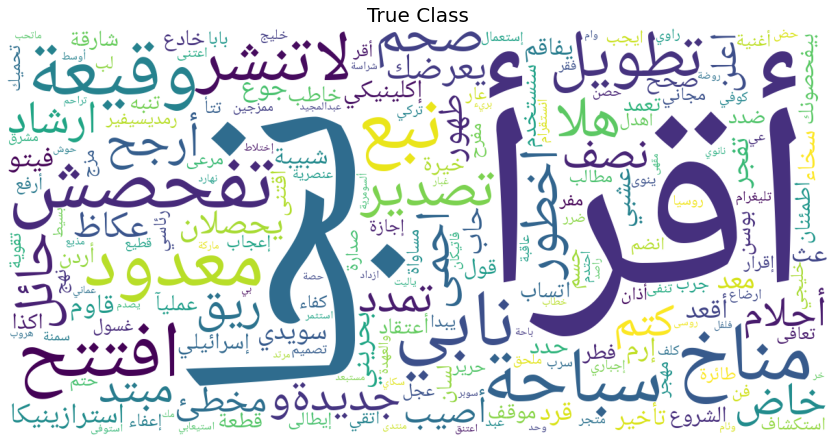

In [ ]:
get_wordcloud(tfidf_dict)

False

In [ ]:
#TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=arabic_stop_words)
tfidf_vectorizer.fit((false_set['tweet_text_NER_STEM']))
tfidf_vectorized = tfidf_vectorizer.transform(false_set['tweet_text_NER_STEM'])
print('The transformed data matrix dimensions:', vectorized.shape)

The transformed data matrix dimensions: (2419, 4637)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد', 'قط', 'كأي', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هاك', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)


In [ ]:


tfidf = tfidf_vectorized.todense()
# TFIDF of words not in the doc will be 0, so replace them with nan
tfidf[tfidf == 0] = np.nan
# Use nanmean of numpy which will ignore nan while calculating the mean
means = np.nanmean(tfidf, axis=0)
# convert it into a dictionary for later lookup
means = dict(zip(tfidf_vectorizer.get_feature_names(), means.tolist()[0]))

tfidf = tfidf_vectorized.todense()
# Argsort the full TFIDF dense vector
ordered = np.argsort(tfidf*-1)
words = tfidf_vectorizer.get_feature_names()
tfidf_dict = {}
top_k = 3
for i in range(len(true_set['tweet_text_NER_STEM'])):
    # Pick top_k from each argsorted matrix for each doc
    for t in range(top_k):
        # Pick the top k word, find its average tfidf from the
        # precomputed dictionary using nanmean and save it to later use
        tfidf_dict[words[ordered[i,t]]] = means[words[ordered[i,t]]]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
tf_idf_dict_sorted=sorted(tfidf_dict.items(), key=lambda item: item[1], reverse=True)

In [ ]:
count=0
for item in tfidf_dict:
  print(item, tfidf_dict[item])
  if count > 20:
    break
  count+=1

جهة 0.4397460203823449
أبيض 0.3280808754696292
كمام 0.17967880253542462
مرفوض 0.3592747530348799
ريس 0.2557150704605499
احترام 0.2960552364823685
سرعيه 0.4812123085222876
زعيم 0.35344664345229954
صاحب 0.2771942959022966
شنو 0.28676174904973933
يالله 0.27487896236326353
عجيب 0.4157554598116825
لقاح 0.1690419446158133
تراكمي 0.26297490897546727
ثوره 0.26297490897546727
بخار 0.3471449657360448
ماء 0.25132530702936245
حلوه 0.2880307876941684
نقاب 0.33019140598650115
وقاية 0.23817081561273043
وضوء 0.2409557894560016
حفظ 0.25098320466946805


In [ ]:
foreign_items=[]
print (len(tfidf_dict))
for token in list(tfidf_dict.keys()):
  if re.search(r'[0-9]+', token):
    foreign_items.append(token)
    tfidf_dict.pop(token)



print(foreign_items)
print(len(tfidf_dict))

3660
['011', '53', '793', 'covid19pandemic', '2000', '2500', '500', 'youm7', '9722878900', '6060', '12', '19', '100', '24', '61', '11', '155', '56', '400', '20', '27', '2020', '700', '2019', '2011', '39', '1993', '21', 'south24', '960', '173', '55', '15', '2017', 'fightcovid19', '2021', '45', '75', '33', '900', 'covid2019', 'n12', '67', '2018', 'covid19dz', '800', '1990', '244', 'covid19', '1510', '32', '37', '6000', '700000', '3500', '000', '1981', '150', '80', '31', '35', '10000', '206', '00000000000000000000000000000', '26', '30', '2600', '58', '10', '95', '600', '51', '72', '101', '1991', '8221', 'ovid19dz', '862', '50000', '90', '448', '2001', '3405', '40', '89', '1000', '3104', '2450']
3572


In [ ]:
foreign_items=[]
print (len(tfidf_dict))
for token in list(tfidf_dict.keys()):
  if re.search(r'[A-Za-z]+', token):
    foreign_items.append(token)
    tfidf_dict.pop(token)



print(foreign_items)
print(len(tfidf_dict))

3572
['loc', 'darkness', 'of', 'per', 'سكوبhd', 'coronavirus', 'phase', 'org', 'misc', 'up', 'stayathomechallenge', 'stayathome', 'staysafe', 'stayhome', 'kspsh', 'indonesia', 'mtvlebanon', 'just', 'blog', 'posted', 'via', 'tag', 'prayforitaly', 'westandwithitaly', 'to', 'sore', 'throat', 'betadine', 'year', 'new', 'on', 'china', 'coronavirusec', 'pona', 'news', 'wontloss', 'it', 'quarantine', 'liars', 'usa', 'uk', 'eden', 'bay', 'wakeup', 'sarin', 'russianvaccine', 'corona', 'covid', 'committowin', 'italy', 'italycoronavirus', 'oat', 'algerie', 'infection', 'control', 'bullet', 'iq', 'in', 'coronadebat', 'algeria', 'mtv', 'who', 'رlحتي', 'pardon', 'world', 'cdf', 'disease', 'coronaviruesue', 'almashadel', 'yamani', 'feedly', 'coronavirusupdate']
3500


In [ ]:
  for token in list(tfidf_dict.keys()):
    text= arabic_reshaper.reshape(token)
    text= get_display(text)
    tfidf_dict[text]=tfidf_dict.pop(token)

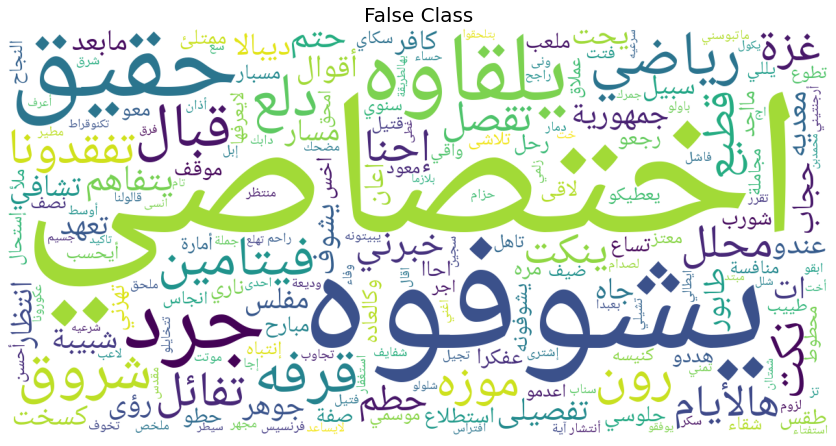

In [ ]:
get_wordcloud(tfidf_dict)

ب